In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

# Drake Passage

In [7]:
M4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_smooth = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_reynolds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-trace-free/output/longmean_00029050.nc', decode_times=False).mean('time')
M32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*.nc', decode_times=False)

In [8]:
e32 = M32.e.isel(xh=0).mean('time').compute()
e4 = M4.e.isel(xh=0).compute()
e4_smooth = M4_smooth.e.isel(xh=0).compute()
e4_reynolds = M4_reynolds.e.isel(xh=0).compute()

In [9]:
def plot_interfaces_Drake(e, label='$1/4^o$', target=e32):
    for zi in range(15):
        target.isel(zi=zi).plot(ls='-', color='k', lw=1)
        e.isel(zi=zi).plot(ls='--', color='b', lw=1)
    e4.isel(zi=-1).plot(color='k') # show bathymetry 
    lats = [-60, -50, -40]
    plt.xticks(lats, [f'${-j}$' for j in lats], rotation=0)
    plt.xlim([-61,-39])
    plt.xlabel('Latitude ($^o$ S)')
    plt.yticks(np.arange(-4000,1000,1000), np.arange(4000,-1000,-1000))
    plt.ylabel('Depth ($m$)')
    plt.title('')
    
    # Layer number
    xoff = {2:-42,5:-45,7:-48,9:-50,11:-51,13:-52}
    for k,x in xoff.items():
        plt.text( x, e32.sel(yh=x,method='nearest')[k:k+2].mean(), '%i'%(k+1), verticalalignment='center', fontsize=10)


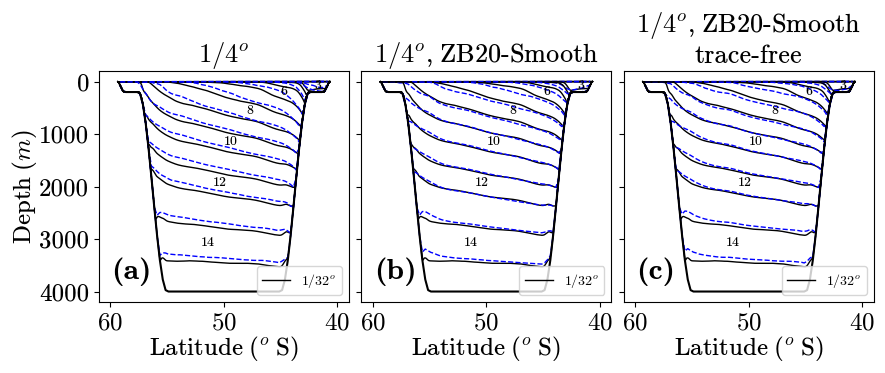

In [13]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.3, 'font.size': 18})
plt.figure(figsize=(10,3))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_smooth, e4_reynolds], 
        ['$1/4^o$', '$1/4^o$, ZB20-Smooth', '$1/4^o$, ZB20-Smooth\ntrace-free']
        )
    ):
    plt.subplot(1,3,col+1)
    plot_interfaces_Drake(e)
    plt.title(label, fontsize=19)
    if col>0:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    plt.plot(np.nan,np.nan,color='k', ls='-', lw=1, label='$1/32^o$')
    plt.legend(loc='lower right', fontsize=10)
        
#plt.plot(np.nan,np.nan,color='b', ls='--', label='Ocean model on a coarse grid')
#plt.plot(np.nan,np.nan,color='k', ls='-', label='$1/32^o$')
#plt.legend(ncol=2, bbox_to_anchor=(-0.55,-0.4), loc='center')
set_letters(fontsize=20, x=0.05,y=0.1)
plt.savefig('Review/NW2-trace-free.pdf')

# Snapshot

In [16]:
def e_to_h(e, h):
    thickness = h * 0
    
    for zl in range(len(h.zl)):
        thickness[{'zl':zl}] = e.isel(zi=zl)-e.isel(zi=zl+1)
    
    return thickness

In [22]:
R32f = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False).isel(time=-1)
R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_smooth = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_reynolds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-trace-free/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)

In [17]:
R32f['h'] = e_to_h(R32f.e, R32f.h)

In [20]:
def KEz(ds):
    return 0.5 * (ds.h * (remesh(ds.u**2, ds.h) + remesh(ds.v**2, ds.h))).sum('zl')

subsample
Colorbar-like object skipped


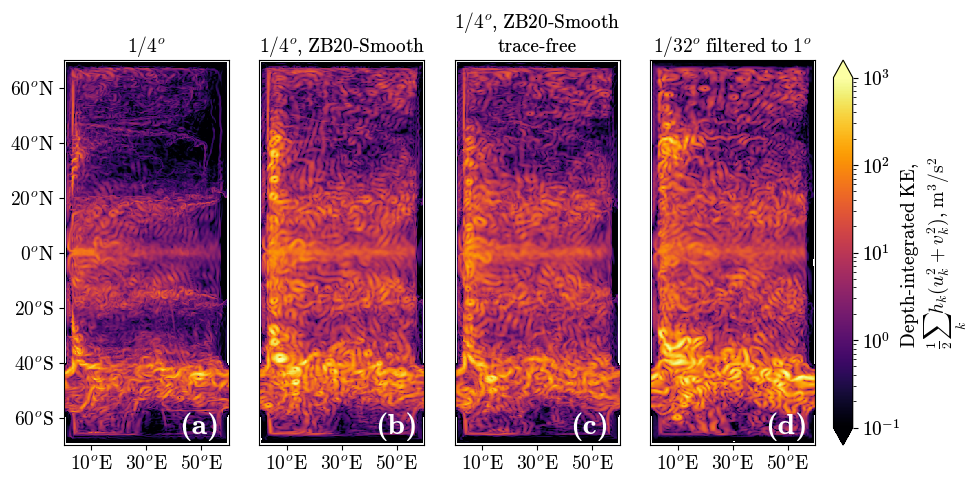

In [23]:
import matplotlib as mpl

default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.3, 'font.size': 14})

plt.figure(figsize=(12,5))
for col, (exp, label) in enumerate(
    zip(
    [R4, R4_smooth, R4_reynolds, R32f],
    ['$1/4^o$', '$1/4^o$, ZB20-Smooth', '$1/4^o$, ZB20-Smooth\ntrace-free', '$1/32^o$ filtered to $1^o$']
    )):
    plt.subplot(1,4,col+1)
    KE = KEz(exp)
    if col==3:
        print('subsample')
        KE = KE.isel(xh=slice(None,None,8), yh=slice(None,None,8))
    im = KE.plot.imshow(
        norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e+3),
        cmap='inferno',
        add_colorbar=False,
        interpolation='none'
    )
    plt.gca().axes.set_aspect('equal')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(label, fontsize=14)
    lons = [10,30,50]
    plt.xticks(lons, [f'${lon}^o$E' for lon in lons])
    if col==0:
        lats = [-60, -40, -20, 0, 20, 40, 60]
        lat_ticks = [f'${-lat}^o$S' if lat<0 else f'${lat}^o$N' for lat in lats]
        plt.yticks(lats, lat_ticks)
    else:
        plt.yticks([])
        
plt.colorbar(im, pad=0.02, ax=plt.gcf().axes, extend='both', label='Depth-integrated KE, \n$\\frac{1}{2} \\sum_k h_k (u_k^2 + v_k^2)$, $\mathrm{m}^3/\mathrm{s}^2$')
set_letters(x=0.7, y=0.03, fontsize=20, color='white')
plt.savefig('Review/NW2-trace-free-snapshot.pdf')

# KE spectrum of surface velocities

In [39]:
R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-4,None))
R4_smooth = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-4,None))
R4_reynolds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-trace-free/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-4,None))

R32f_R1 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False)
R32f_R2 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-snapshots.nc', decode_times=False)
R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots_00002705.nc', decode_times=False).isel(time=slice(None,None,6))

In [40]:
M4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/longmean_00029050.nc', decode_times=False)
M4_smooth = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/longmean_00029050.nc', decode_times=False)
M4_reynolds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-trace-free/output/longmean_00029050.nc', decode_times=False)

M32f_R1 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-longmean.nc', decode_times=False)
M32f_R2 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-longmean.nc', decode_times=False)
M32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*.nc', decode_times=False)

In [41]:
import xrft
def KE_spectrum(u, v, dx_mean=1):    
    x = dx_mean*np.arange(len(u.xh))
    u['xh'] = x
    v['xh'] = x
    
    spec = lambda val: xrft.power_spectrum(val, dim='xh', window='hann', nfactor=2,truncate=True, detrend='linear', window_correction=False)
    
    # KE is half the power spectrum
    sp = (spec(u) + spec(v))/2
    
    # Normalize to angular frequencies
    sp['freq_xh'] = sp['freq_xh'] * 2 * np.pi
    sp = sp / (2 * np.pi)
    freq = sp.freq_xh
    sp = sp.where(freq>0)
    
    return sp.mean('time').compute()

In [42]:
def SKE_spectrum(ds, ds_mean):
    ssu = ds.u.isel(zl=0) - ds_mean.u.isel(zl=0).mean('time')
    ssv = ds.v.isel(zl=0) - ds_mean.v.isel(zl=0).mean('time')
    
    ssu = remesh(ssu, ds.h)
    ssv = remesh(ssv, ds.h)
    
    # remove 2.5 Lon from boundaries similarly to Marques
#     ssu = ssu.sel(xh = slice(2.5, 57.5))
#     ssv = ssv.sel(xh = slice(2.5, 57.5))
    
    if len(ds.xh)==240:
        dx_mean = 21383.6332011
    elif len(ds.xh)==1920:
        dx_mean = 21383.6332011 / 8
    else:
        print('Define dx_mean')
    
    return KE_spectrum(ssu,ssv,dx_mean)

In [43]:
from dask.diagnostics import ProgressBar

In [44]:
with ProgressBar():
    R32_spec = SKE_spectrum(R32,M32)
    R32f_R1_spec = SKE_spectrum(R32f_R1,M32f_R1)
    R32f_R2_spec = SKE_spectrum(R32f_R2,M32f_R2)
    R4_spec = SKE_spectrum(R4,M4)
    smooth_spec = SKE_spectrum(R4_smooth,M4_smooth)
    reynolds_spec = SKE_spectrum(R4_reynolds,M4_reynolds)

[########################################] | 100% Completed | 25.11 ss
[########################################] | 100% Completed | 6.65 sms
[########################################] | 100% Completed | 6.86 sms
[########################################] | 100% Completed | 1.11 sms
[########################################] | 100% Completed | 1.11 sms
[########################################] | 100% Completed | 907.78 ms


(0.0001, 10000.0)

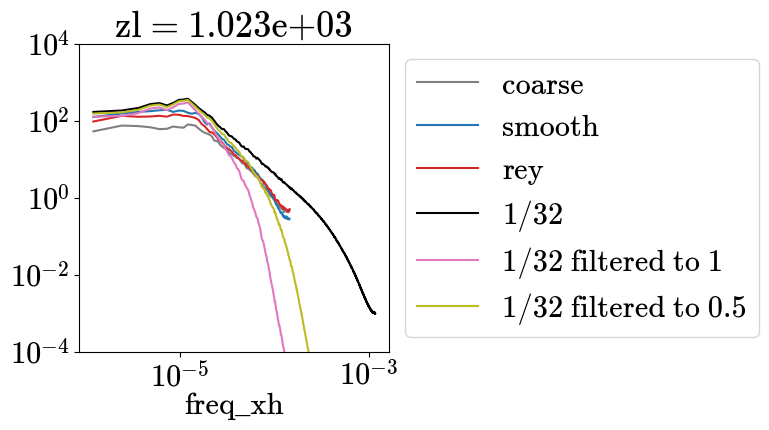

In [45]:
sel = lambda x : x.sel(yh=slice(None,None)).mean('yh')
sel(R4_spec).plot(color='gray', label='coarse')
sel(smooth_spec).plot(color='tab:blue', label='smooth')
sel(reynolds_spec).plot(color='tab:red', label='rey')
sel(R32_spec).plot(color='k', label='1/32')
sel(R32f_R1_spec).plot(color='tab:pink', label='1/32 filtered to 1')
sel(R32f_R2_spec).plot(color='tab:olive', label='1/32 filtered to 0.5')
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.ylim([1e-4,1e+4])

## Combined figure

In [10]:
yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

In [47]:
stats_R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()
stats_smooth = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()
stats_reynolds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-trace-free/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()

In [48]:
def KE(ds):
    return ds.KE.sum('Layer')
def APE(ds):
    return ds.APE.sum('Interface')

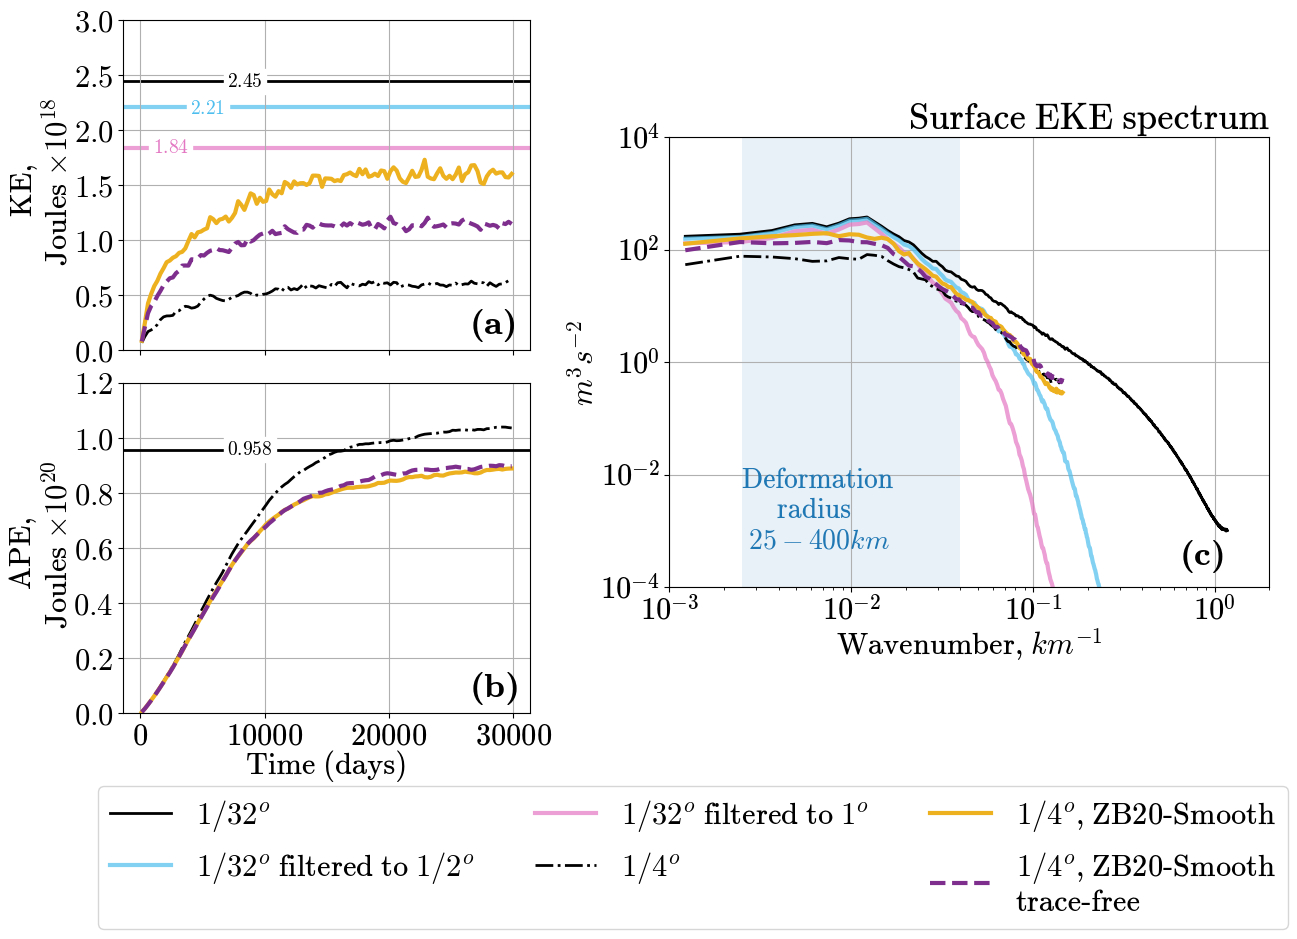

In [54]:
default_rcParams({'figure.subplot.wspace': 0.8, 'figure.subplot.hspace': 0.1,
                  'font.size': 22,  'axes.formatter.limits': (-5,5),
                 })
fig = plt.figure(figsize=(12,9))
import matplotlib.colors as mcolors

gs = fig.add_gridspec(2,4)

plt.sca(fig.add_subplot(gs[0, 0:2]))

plt.axhline(y=2.4482846764501053e+18, color='k', ls='-', lw=2, zorder=-1, label='$1/32^o$')
plt.axhline(y=2.2143647793008573e+18, color=lightblue, ls='-', lw=3, alpha=0.7, zorder=-1, label='$1/32^o$ filtered to $1/2^o$')
plt.axhline(y=1.840343192972326e+18, color='tab:pink', ls='-', lw=3, alpha=0.7, zorder=-1, label='$1/32^o$ filtered to $1^o$')

plt.text(7000,2.4e+18,'$2.45$', backgroundcolor='white', color='k', fontsize=14)
plt.text(4000,2.15e+18,'$2.21$', backgroundcolor='white', color=lightblue, fontsize=14)
plt.text(1000,1.8e+18,'$1.84$', backgroundcolor='white', color='tab:pink', fontsize=14)


KE(stats_R4).plot(color='k', ls='-.', label='$1/4^o$', lw=2)
KE(stats_smooth).plot(color=yellow, label='$1/4^o$, ZB20-Smooth', lw=3)
KE(stats_reynolds).plot(color=violet, label='$1/4^o$, ZB20-Smooth\ntrace-free', lw=3, ls='--')


plt.ylabel('KE, \n Joules $\\times 10^{18}$')
plt.ylim([0, 3e+18])
plt.yticks([0, 0.5e+18,1e+18,1.5e+18,2.0e+18,2.5e+18,3e+18], ['$0.0$', '$0.5$', '$1.0$', '$1.5$', '$2.0$', '$2.5$', '$3.0$'])
#plt.yticks([0, 0.6e+18,1.2e+18,1.8e+18,2.4e+18,3.0e+18], ['$0.0$', '$0.6$', '$1.2$', '$1.8$', '$2.4$', '$3.0$'])
plt.xlabel('')
plt.xticks([0, 10000, 20000, 30000], [None]*4)
plt.grid()

plt.legend(loc = 'lower center', fontsize=22, bbox_to_anchor=(1.4,-1.8), ncol=3)

plt.sca(fig.add_subplot(gs[1, 0:2]))
plt.axhline(y=9.584091697350959e+19, color='k', ls='-', lw=2)
plt.text(7000,9.4e+19,'$0.958$', backgroundcolor='white', color='k', fontsize=14)


APE(stats_R4).plot(color='k', label='$1/4^o$', lw=2, ls='-.')
APE(stats_smooth).plot(color=yellow, label='$1/4^o$, ZB-Smooth', lw=3)
APE(stats_reynolds).plot(color=violet, label='$1/4^o$, ZB-Smooth\ntrace-free', lw=3, ls='--')

plt.ylabel('APE, \n Joules $\\times 10^{20}$')
#plt.title('APE',loc='right')
plt.ylim([0, 1.2e+20])
plt.grid()

plt.yticks([0, 0.2e+20, 0.4e+20, 0.6e+20, 0.8e+20, 1.0e+20, 1.2e+20], ["$0.0$", "$0.2$", "$0.4$", "$0.6$", "$0.8$", "$1.0$", "$1.2$"])
#plt.yticks([0, 0.3e+20, 0.6e+20, 0.9e+20, 1.2e+20], ["$0.0$", "$0.3$", "$0.6$", "$0.9$", "$1.2$"])

plt.xlabel('Time (days)')


#plt.sca(fig.add_subplot(gs[0:2, 2:4]))
ax = plt.gcf().add_axes([0.58, 0.25, 0.5,0.5])
plt.sca(ax)
def sel(x):
    y = x.sel(yh=slice(None,None)).mean('yh')
    y['freq_xh'] = y['freq_xh'] * 1e+3
    return y
sel(R32_spec).plot(color='k', ls='-', lw=2)
sel(R32f_R2_spec).plot(color=lightblue, ls='-', lw=3, alpha=0.7)
sel(R32f_R1_spec).plot(color='tab:pink', ls='-', lw=3, alpha=0.7)

sel(R4_spec).plot(color='k', lw=2, ls='-.')
sel(smooth_spec).plot(color=yellow, lw=3)
sel(reynolds_spec).plot(color=violet, lw=3, ls='--')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,1e+4])
plt.yticks([1e-4, 1e-2, 1e0, 1e+2, 1e+4])
plt.title('Surface EKE spectrum', loc='right')
plt.title('')
plt.ylabel('$m^3s^{-2}$')
plt.xlabel('Wavenumber, $km^{-1}$')
plt.xticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlim([1e-3, 2])
plt.grid()

Rd1 = 400
Rd2 = 25
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(2.5e-3,5e-4,'Deformation \n     radius \n $25-400km$', fontsize=20, color='tab:blue')


# k = np.array([1e-2,1e0])
# plt.plot(k, 3e-1*k**(-2))

#plt.gcf().align_labels()
set_letters(x=0.85, y=0.05, fontsize=24)
plt.savefig('Review/NW2-trace-free-series-spectrum')

# Video

In [3]:
def e_to_h(e, h):
    thickness = h * 0
    
    for zl in range(len(h.zl)):
        thickness[{'zl':zl}] = e.isel(zi=zl)-e.isel(zi=zl+1)
    
    return thickness

In [11]:
R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/snapshots_*', decode_times=False, chunks={'time':1})
R4_smooth = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/snapshots_*', decode_times=False, chunks={'time':1})
R4_smooth_trace_free = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-trace-free/output/snapshots_*', decode_times=False, chunks={'time':1})

In [39]:
%%time 
R32 = xr.open_mfdataset(
    '/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots*.nc', 
    decode_times=False, chunks={'time':1}).isel(time=slice(None,None,6)).isel(xh=slice(None,None,8), yh=slice(None,None,8), xq=slice(None,None,8), yq=slice(None,None,8))[['u', 'v', 'h']].load()

CPU times: user 39.6 s, sys: 5.9 s, total: 45.5 s
Wall time: 1min 3s


In [40]:
def KEz(ds):
    return 0.5 * (ds.h * (remesh(ds.u**2, ds.h) + remesh(ds.v**2, ds.h))).sum('zl')

In [41]:
import matplotlib as mpl

default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.3, 'font.size': 14})
def plot(idx=-1):
    plt.figure(figsize=(12,5))
    for col, (exp, label) in enumerate(
        zip(
        [R4, R4_smooth, R4_smooth_trace_free, R32],
        ['$1/4^o$', '$1/4^o$, ZB20-Smooth', '$1/4^o$, ZB20-Smooth\ntrace-free', '$1/32^o$']
        )):
        plt.subplot(1,4,col+1)
        KE = KEz(exp)
        idx_ = idx
        if col==3:
            idx_ = idx % 27
        im = KE.isel(time=idx_).plot.imshow(
            norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e+3),
            cmap='inferno',
            add_colorbar=False,
            interpolation='none'
        )
        plt.gca().axes.set_aspect('equal')
        plt.xlabel('')
        plt.ylabel('')
        plt.title(label, fontsize=14)
        lons = [10,30,50]
        plt.xticks(lons, [f'${lon}^o$E' for lon in lons])
        if col==0:
            lats = [-60, -40, -20, 0, 20, 40, 60]
            lat_ticks = [f'${-lat}^o$S' if lat<0 else f'${lat}^o$N' for lat in lats]
            plt.yticks(lats, lat_ticks)
        else:
            plt.yticks([])

    plt.colorbar(im, pad=0.02, ax=plt.gcf().axes, extend='both', label='Depth-integrated KE, \n$\\frac{1}{2} \\sum_k h_k (u_k^2 + v_k^2)$, $\mathrm{m}^3/\mathrm{s}^2$')
#    set_letters(x=0.7, y=0.03, fontsize=20, color='white')

CPU times: user 4.38 s, sys: 2.35 s, total: 6.73 s
Wall time: 6.52 s


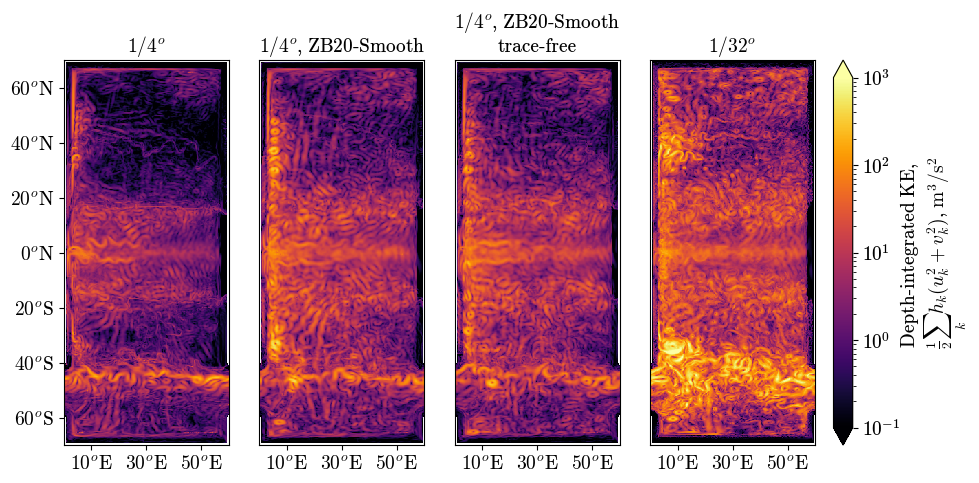

In [45]:
%time plot(100)

In [47]:
create_animation_ffmpeg(plot, range(800,1000), 'Review/NW2-trace-free-steady.mp4', dpi=150, FPS=15)

Native resolution of snapshots is used: 1460x718

Animation Review/NW2-trace-free-steady.mp4 at FPS=15 will last for 13.3 seconds. The frames are saved to 
.ffmpeg/Review/NW2-trace-free-steady



ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

# Increasing scaling coefficient

In [2]:
stats_R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()
stats_smooth = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()
stats_smooth_free = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-trace-free/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()
stats_smooth_free_3 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-trace-free-3.0/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()

In [2]:
def KE(ds):
    return ds.KE.sum('Layer')
def APE(ds):
    return ds.APE.sum('Interface')

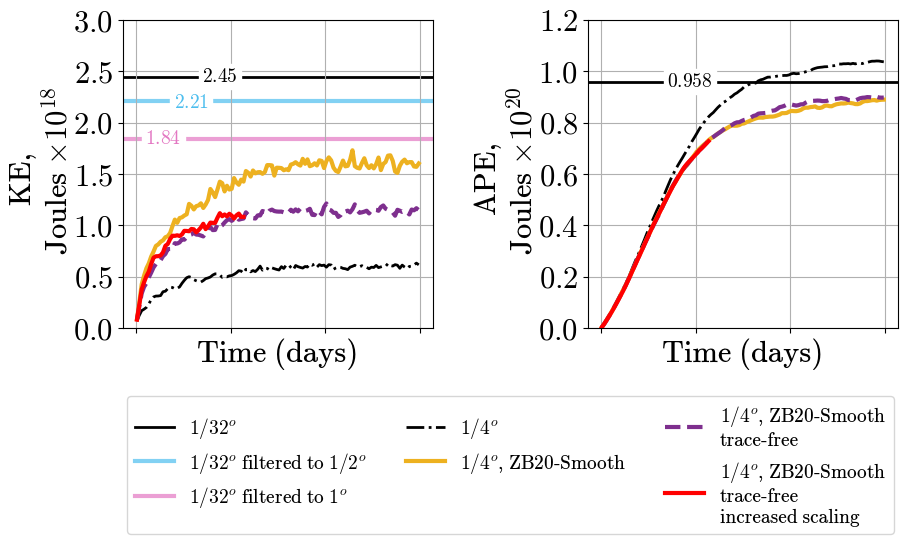

In [34]:
default_rcParams({'figure.subplot.wspace': 0.5, 'figure.subplot.hspace': 0.1,
                  'font.size': 22,  'axes.formatter.limits': (-5,5),
                 })
fig = plt.figure(figsize=(10,4))
import matplotlib.colors as mcolors

gs = fig.add_gridspec(1,2)

plt.sca(fig.add_subplot(gs[0, 0]))

plt.axhline(y=2.4482846764501053e+18, color='k', ls='-', lw=2, zorder=-1, label='$1/32^o$')
plt.axhline(y=2.2143647793008573e+18, color=lightblue, ls='-', lw=3, alpha=0.7, zorder=-1, label='$1/32^o$ filtered to $1/2^o$')
plt.axhline(y=1.840343192972326e+18, color='tab:pink', ls='-', lw=3, alpha=0.7, zorder=-1, label='$1/32^o$ filtered to $1^o$')

plt.text(7000,2.4e+18,'$2.45$', backgroundcolor='white', color='k', fontsize=14)
plt.text(4000,2.15e+18,'$2.21$', backgroundcolor='white', color=lightblue, fontsize=14)
plt.text(1000,1.8e+18,'$1.84$', backgroundcolor='white', color='tab:pink', fontsize=14)


KE(stats_R4).plot(color='k', ls='-.', label='$1/4^o$', lw=2)
KE(stats_smooth).plot(color=yellow, label='$1/4^o$, ZB20-Smooth', lw=3)
KE(stats_smooth_free).plot(color=violet, label='$1/4^o$, ZB20-Smooth\ntrace-free', lw=3, ls='--')
KE(stats_smooth_free_3).plot(color='r', label='$1/4^o$, ZB20-Smooth\ntrace-free\nincreased scaling', lw=3, ls='-')


plt.ylabel('KE, \n Joules $\\times 10^{18}$')
plt.ylim([0, 3e+18])
plt.yticks([0, 0.5e+18,1e+18,1.5e+18,2.0e+18,2.5e+18,3e+18], ['$0.0$', '$0.5$', '$1.0$', '$1.5$', '$2.0$', '$2.5$', '$3.0$'])
plt.xlabel('Time (days)')
plt.xticks([0, 10000, 20000, 30000], [None]*4)
plt.grid()

plt.legend(loc = 'lower center', fontsize=14, bbox_to_anchor=(1.25,-0.7), ncol=3)

plt.sca(fig.add_subplot(gs[0, 1]))
plt.axhline(y=9.584091697350959e+19, color='k', ls='-', lw=2)
plt.text(7000,9.4e+19,'$0.958$', backgroundcolor='white', color='k', fontsize=14)


APE(stats_R4).plot(color='k', label='$1/4^o$', lw=2, ls='-.')
APE(stats_smooth).plot(color=yellow, label='$1/4^o$, ZB-Smooth', lw=3)
APE(stats_smooth_free).plot(color=violet, label='$1/4^o$, ZB-Smooth\ntrace-free', lw=3, ls='--')
APE(stats_smooth_free_3).plot(color='r', label='$1/4^o$, ZB-Smooth\ntrace-free\nincreased scaling', lw=3, ls='-')

plt.ylabel('APE, \n Joules $\\times 10^{20}$')
#plt.title('APE',loc='right')
plt.ylim([0, 1.2e+20])
plt.grid()

plt.yticks([0, 0.2e+20, 0.4e+20, 0.6e+20, 0.8e+20, 1.0e+20, 1.2e+20], ["$0.0$", "$0.2$", "$0.4$", "$0.6$", "$0.8$", "$1.0$", "$1.2$"])
plt.xticks([0, 10000, 20000, 30000], [None]*4)

plt.xlabel('Time (days)')
plt.savefig('Review/NW2-trace-free-series-3.0.pdf')

# Jansen Held

In [29]:
stats_R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/ocean.stats.nc', decode_times=False)
stats_JH = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld/output/ocean.stats.nc', decode_times=False)
stats_JH_02 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Cs-0.2/output/ocean.stats.nc', decode_times=False)
stats_JH_KS = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Yankovsky/ocean.stats.nc', decode_times=False)

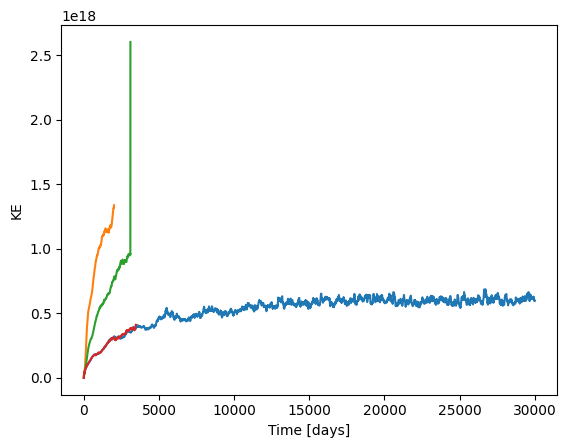

In [30]:
KE(stats_R4).plot()
KE(stats_JH).plot()
KE(stats_JH_02).plot()
KE(stats_JH_KS).plot()

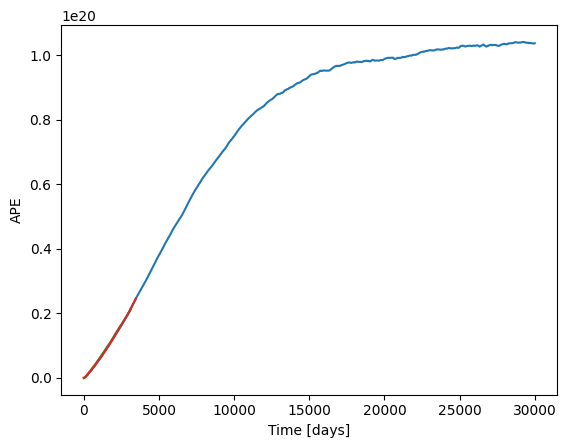

In [31]:
APE(stats_R4).plot()
APE(stats_JH).plot()
APE(stats_JH_02).plot()
APE(stats_JH_KS).plot()

In [35]:
ds = xr.open_dataset(
    '/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Cs-0.2/output/snapshots_00002010.nc', decode_times=False)

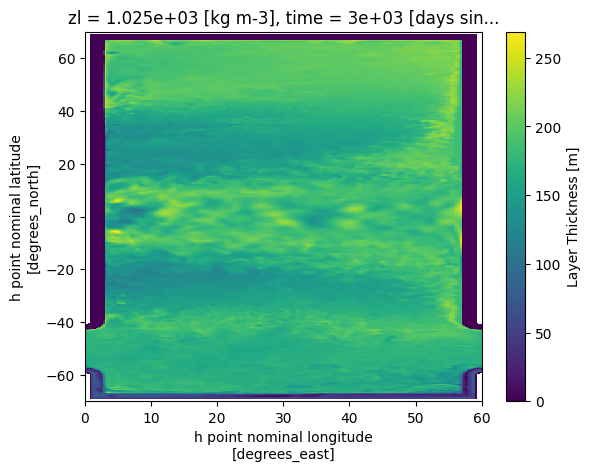

In [43]:
ds.h.isel(time=-1,zl=-10).plot()